In [49]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
% matplotlib inline

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
pd.options.display.float_format = '{:.3f}'.format


postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
                       
weather_df = pd.read_sql_query('select * from weatherinszeged',con = engine)

engine.dispose()

weather_df.head(10)

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.
5,2006-04-01 03:00:00+00:00,Partly Cloudy,rain,9.222,7.111,0.850,13.959,258.000,14.957,0.000,1016.660,Partly cloudy throughout the day.
6,2006-04-01 04:00:00+00:00,Partly Cloudy,rain,7.733,5.522,0.950,12.365,259.000,9.982,0.000,1016.720,Partly cloudy throughout the day.
7,2006-04-01 05:00:00+00:00,Partly Cloudy,rain,8.772,6.528,0.890,14.152,260.000,9.982,0.000,1016.840,Partly cloudy throughout the day.
8,2006-04-01 06:00:00+00:00,Partly Cloudy,rain,10.822,10.822,0.820,11.318,259.000,9.982,0.000,1017.370,Partly cloudy throughout the day.
9,2006-04-01 07:00:00+00:00,Partly Cloudy,rain,13.772,13.772,0.720,12.526,279.000,9.982,0.000,1017.220,Partly cloudy throughout the day.


In [50]:
### load the model

X = weather_df[['humidity','windspeed','windbearing','pressure']]
Y = weather_df['temperature']

lrm = linear_model.LinearRegression()

lrm.fit(x,y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ -3.24962454e+01  -2.01413742e-01   4.04836936e-03  -6.91759209e-04]

Intercept: 
 37.9264381853


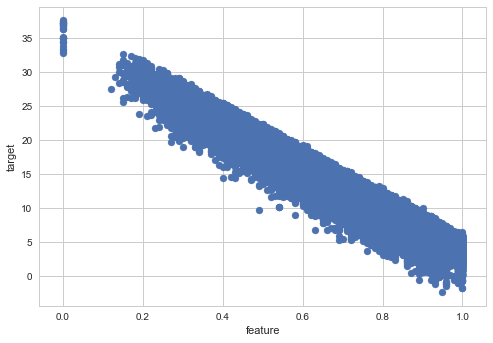

In [67]:
# predictions of the linear regression
predictions = lrm.predict(x)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(weather_df['humidity'], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.show()

### shows linear relationship

### errors are zero on average

In [52]:
errors = y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -1.9624955657832385e-15


### homoscedasticity

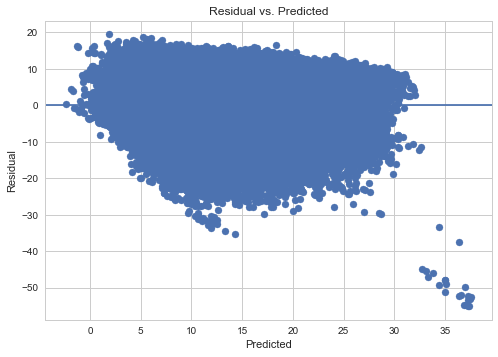

In [53]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [54]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


#### stat tests and graph show that it residuals vary between high and low predicted values 

In [55]:
### test multicolinearity

x.corr()

,humidity,windspeed,windbearing,pressure
humidity,1.000,-0.225,0.001,0.005
windspeed,-0.225,1.000,0.104,-0.049
windbearing,0.001,0.104,1.000,-0.012
pressure,0.005,-0.049,-0.012,1.000


#### not correlated... lets also check graph

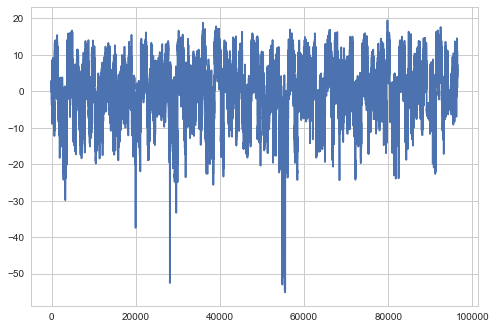

In [56]:
plt.plot(errors)
plt.show()

### and autocorrelate

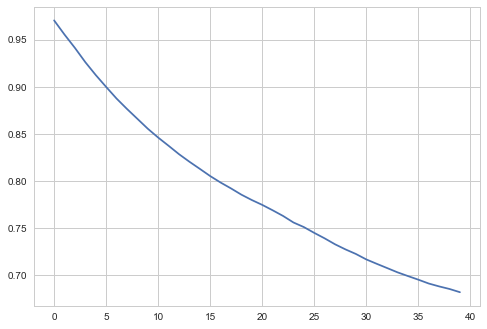

In [57]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

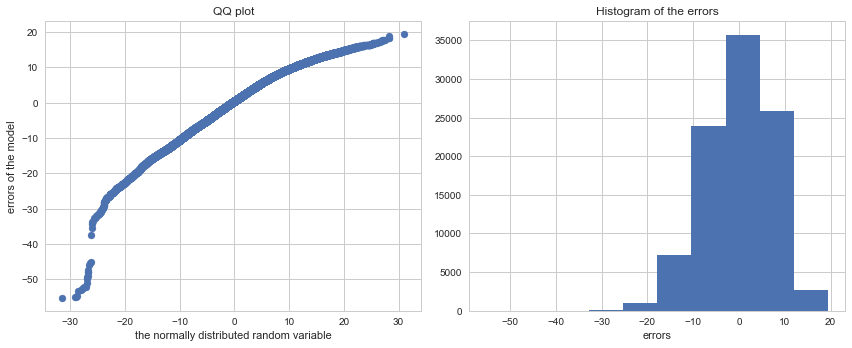

In [58]:
### high autocorrelation 

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [59]:
### lets use stat test 

from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [60]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.296735252356 and p value is 0.0
Normality test statistics is 3375.4323076995797 and p value is 0.0


In [61]:
### not normally distributed

# houseprices 

In [69]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
hp_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [70]:
hp_df = pd.concat([hp_df,pd.get_dummies(hp_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
hp_df = pd.concat([hp_df,pd.get_dummies(hp_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(hp_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(hp_df.street, prefix="street", drop_first=True).columns)


In [71]:
X = hp_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]
Y = hp_df.saleprice

In [73]:
lrm = linear_model.LinearRegression()

lrm.fit(X,Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)



Coefficients: 
 [  2.33265353e+04   4.56343565e+01   1.34501364e+04   1.64082048e+01
   2.83816393e+01   2.50875137e+04   1.34204564e+04   2.85658560e+04
   9.04778936e+03   1.51037622e+02]

Intercept: 
 -117337.728714


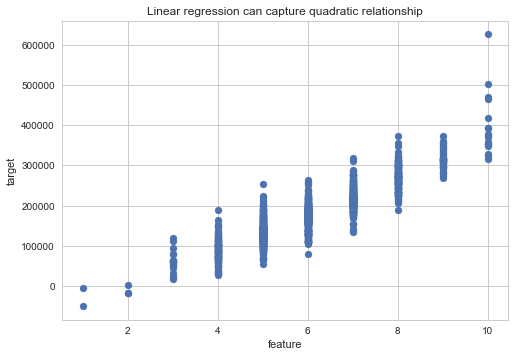

In [76]:
## the first assumption is met (linear relationship between features and target coef)

plt.scatter(hp_df["overallqual"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

In [77]:
predictions = lrm.predict(X)

errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -1.8698214361928913e-11


### Homoscedasticity

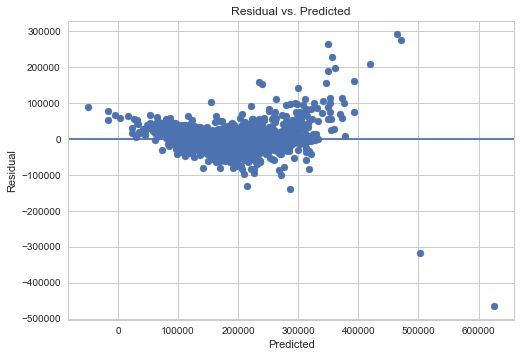

In [78]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [79]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 497.754 and p value is 2.93e-110
Levene test statistic value is 491.982 and p value is 7.29e-101


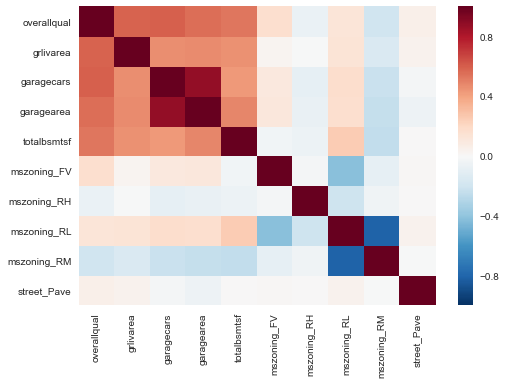

In [82]:
sns.heatmap(X.corr())

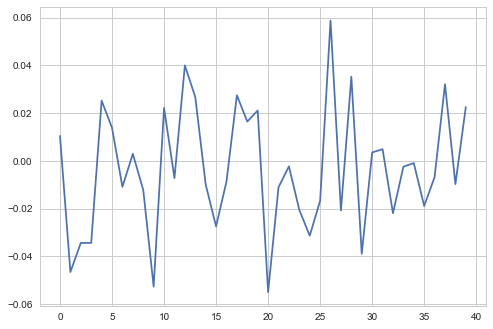

In [83]:
### we can see multiconllineary in effect 

from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

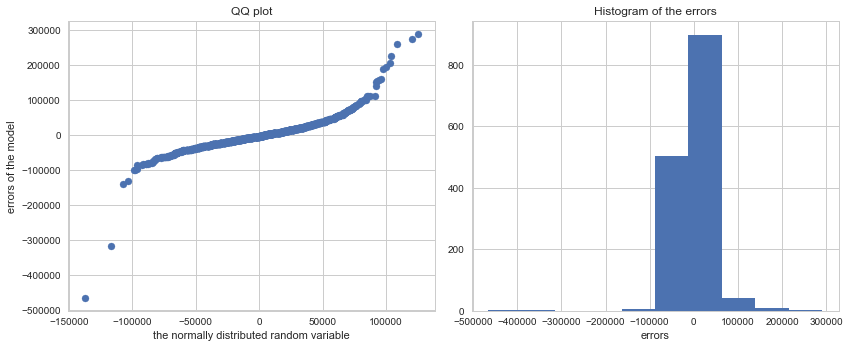

In [84]:

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [85]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 41281.526018266035 and p value is 0.0
Normality test statistics is 415.8826568586297 and p value is 4.922984898067215e-91


### as we can see some of the assumptions are not met 

We probably have to do a PCA to eliminate the multicolinearity as well as transforming our dependent variable to be normally distributed